### Password strength Prediction

To import a sqlite database 1) form a sql connection (sqlite3 package) 2) run the sql query (panda package).

In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Collection

In [3]:
import sqlite3
con = sqlite3.connect('password_data.sqlite')

In [4]:
df=pd.read_sql_query('select * from Users',con) # Users is the table name

In [5]:
df.head(3)

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1
2,2,soporte13,1


### Data cleaning 
1. removing duplicate values
2. dealing with missing values
3. removing irrelevant rows

In [6]:
df.drop('index',axis=1,inplace=True) 

In [7]:
df.head()

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2
4,c443balg,1


In [8]:
df.isnull().any()

password    False
strength    False
dtype: bool

In [9]:
df.duplicated().sum()

0

In [10]:
df.dtypes #int64 can store -ve values lets check if any -ve values

password    object
strength     int64
dtype: object

In [11]:
df['strength'].unique() # no irrelevant row in strength

array([1, 2, 0])

### Data Analysis 
Semantic Analysis

In [12]:
#1. How many passwords hold only numeric characters
len(df[df['password'].str.isnumeric()])

26

In [13]:
#2. How many passwords hold only alphabet 
len(df[df['password'].str.isalpha()])

50

In [14]:
#3. How many passwords hold alpha-numerics characters
len(df[df['password'].str.isalnum()])

97203

In [15]:
#4. How many passwords hold only upper-case characters
len(df[df['password'].str.isupper()])

1506

In [16]:
#5. How many passwords hold title-case character
len(df[df['password'].str.istitle()])

932

In [17]:
#6. How many passwords hole some special character
import string

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def has_spcl_char(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [20]:
len(df[df['password'].apply(has_spcl_char)==1])

2663

### Feature Engineering

In [21]:
df.head(5)

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2
4,c443balg,1


In [22]:
df['length']=df['password'].str.len()

In [23]:
def lowercase_freq(row):
    return len([char for char in row if char.islower()])/len(row)
def uppercase_freq(row):
    return len([char for char in row if char.isupper()])/len(row)
def numeric_freq(row):
    return len([char for char in row if char.isdigit()])/len(row)
def splchar_freq(row):
    return len([char for char in row if char in string.punctuation])/len(row)

In [24]:
df['lower_freq']=np.round(df['password'].apply(lowercase_freq),3)
df['upper_freq']=np.round(df['password'].apply(uppercase_freq),3)
df['num_freq']=np.round(df['password'].apply(numeric_freq),3)
df['splchar_freq']=np.round(df['password'].apply(splchar_freq),3)

In [25]:
df.head(2)

,password,strength,length,lower_freq,upper_freq,num_freq,splchar_freq
0,zxe870819,1,9,0.333,0.0,0.667,0.0
1,xw46454nr23l,1,12,0.417,0.0,0.583,0.0


#### Data Analysis on new features 
To find which features are important

Descriptive statistics (mean,median,max,min)

In [26]:
pd.crosstab(df['length'],df['strength'])

strength,0,1,2
length,,,
1,1,0,0
2,1,0,0
3,5,0,0
4,2,0,0
5,25,0,0
6,6030,0,0
7,7558,0,0
8,0,16782,0
9,0,21570,0


In [27]:
cols=['length', 'lower_freq', 'num_freq',
       'splchar_freq', 'upper_freq']

In [28]:
for col in cols:
    print(df[[col,'strength']].groupby(['strength']).agg(['min','max','mean','median']))
    print('----------------------------------------')

         length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0
----------------------------------------
         lower_freq                        
                min    max      mean median
strength                                   
0               0.0  1.000  0.708050  0.714
1               0.0  0.923  0.630067  0.667
2               0.0  0.917  0.424679  0.400
----------------------------------------
         num_freq                        
              min    max      mean median
strength                                 
0             0.0  1.000  0.275383  0.286
1             0.0  0.923  0.360123  0.333
2             0.0  0.895  0.193796  0.188
----------------------------------------
         splchar_freq                        
                  min    max      mean median
strength                           

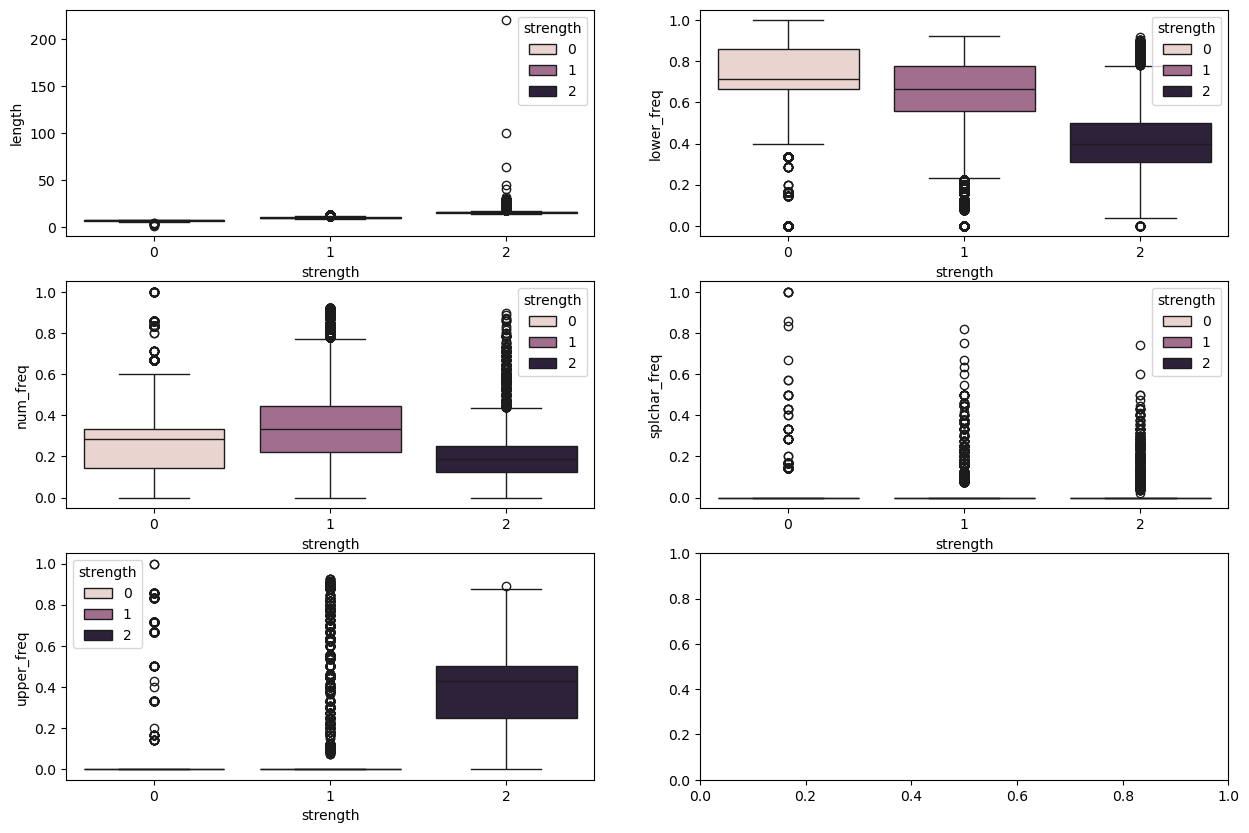

In [29]:
# Box-plots of features

fig,ax=plt.subplots(3,2,figsize=(15,10))
j=-1
i=0
for col in cols:
    i=i%2
    if i==0:
        j=j+1
    sns.boxplot(x='strength',y=col,hue='strength',ax=ax[j][i],data=df)
    i=i+1

In [30]:
# violin and distribution plots
def plot(col):
    fig,ax=plt.subplots(1,2,figsize=(15,10))
    sns.violinplot(x='strength',y=col,data=df,ax=ax[0])
    sns.distplot(df[df['strength']==0][col],color='red',label='0',hist=False)
    sns.distplot(df[df['strength']==1][col],color='blue',label='1',hist=False)
    sns.distplot(df[df['strength']==2][col],color='orange',label='2',hist=False)
    plt.suptitle('Distribution of '+col)
    plt.legend()

In [31]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

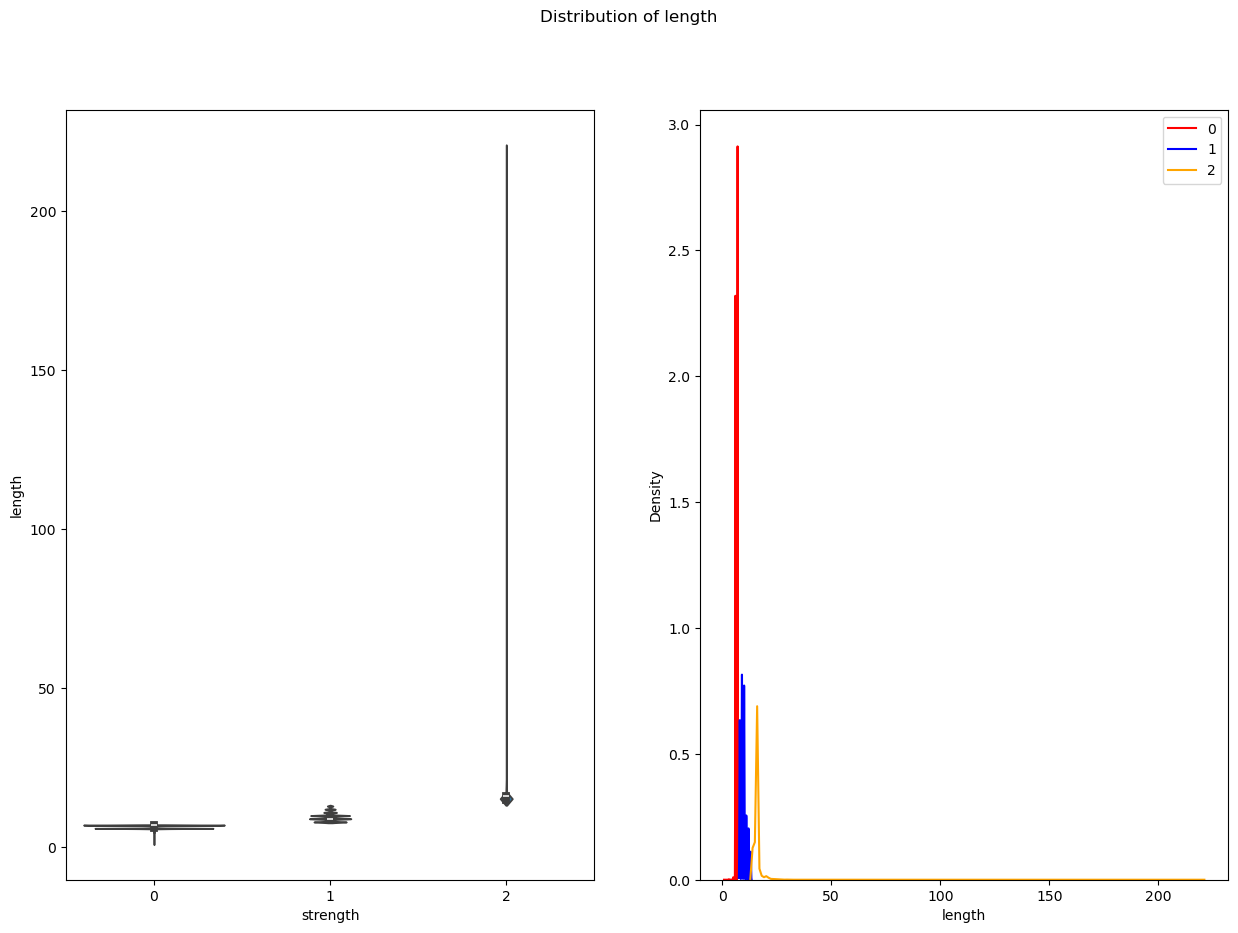

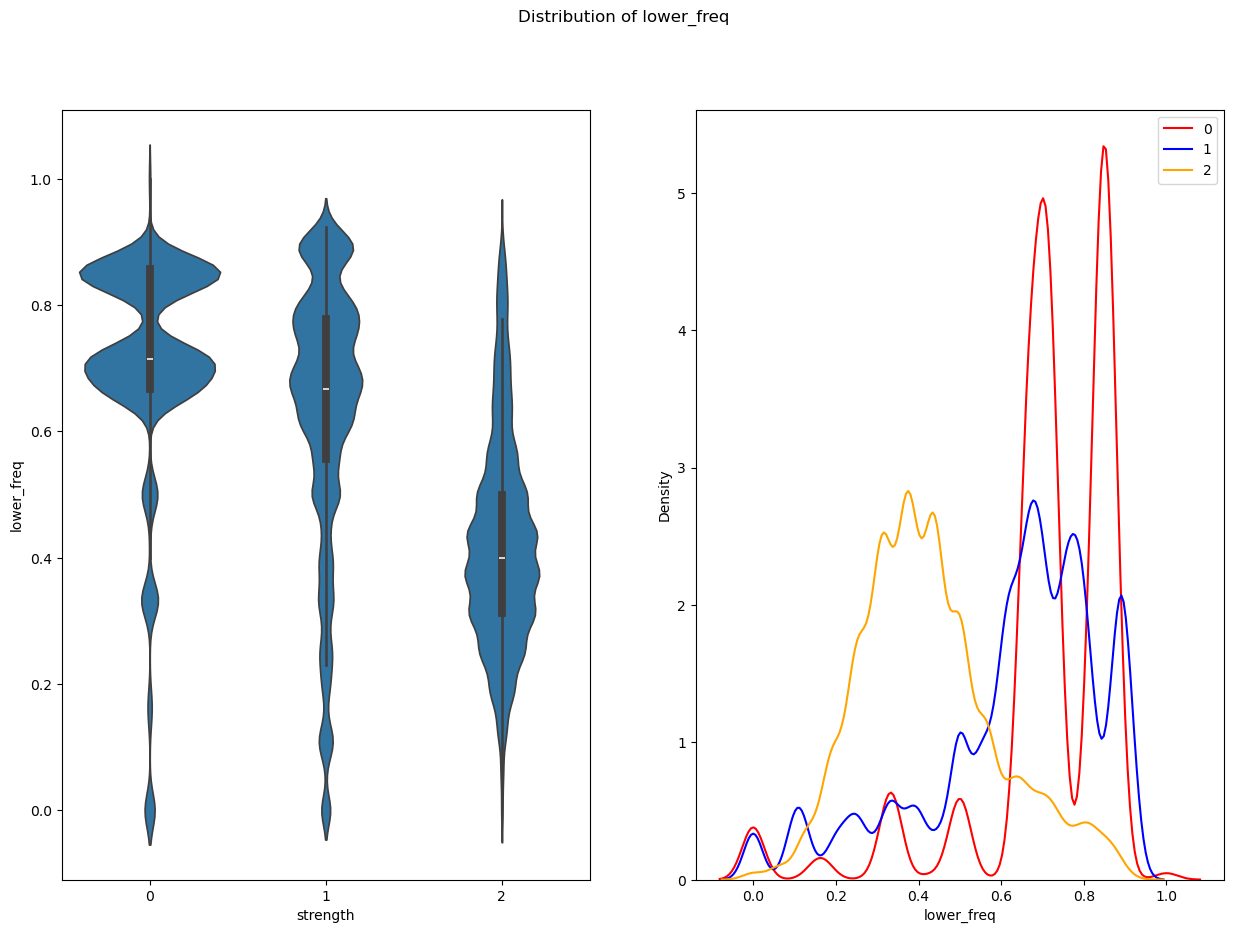

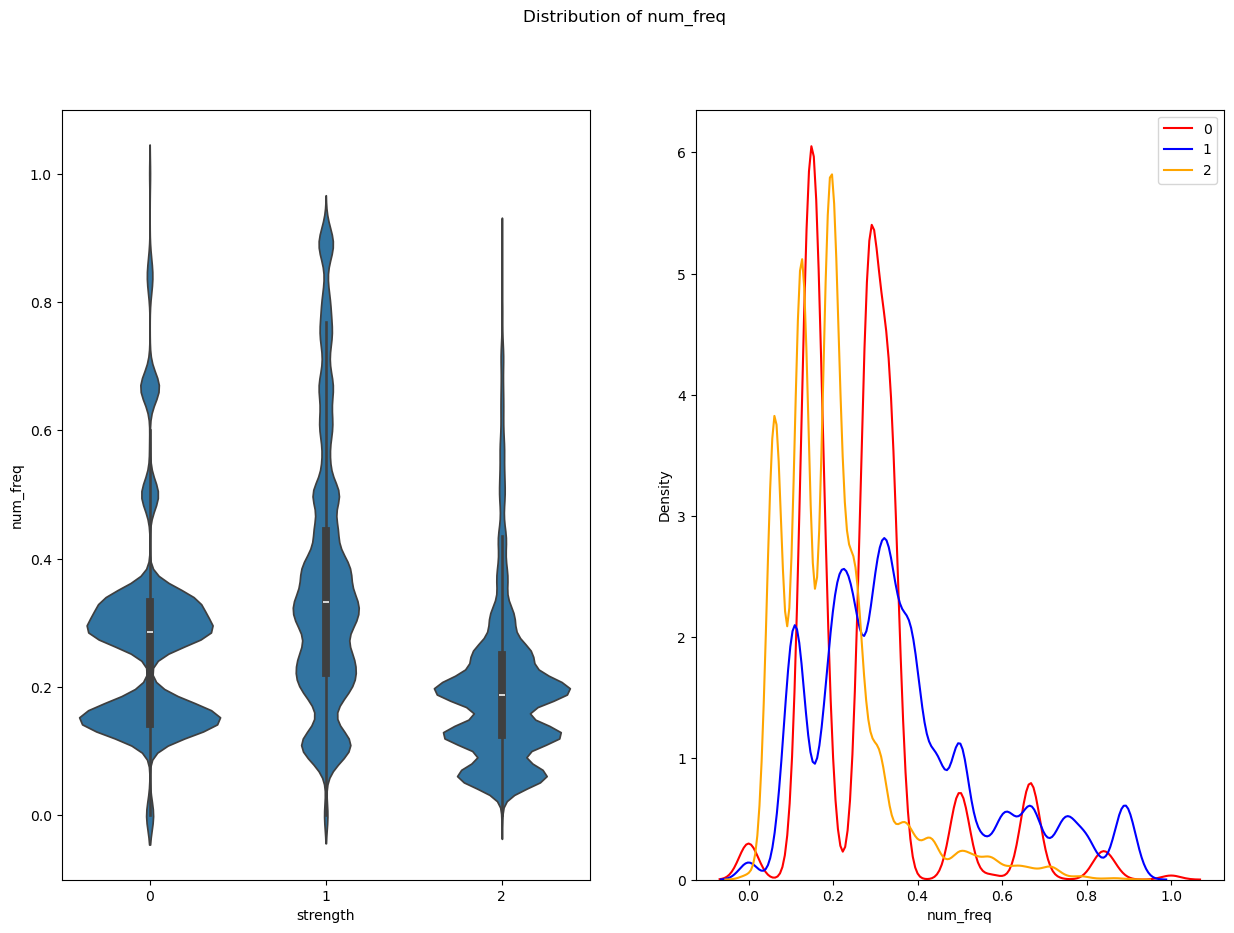

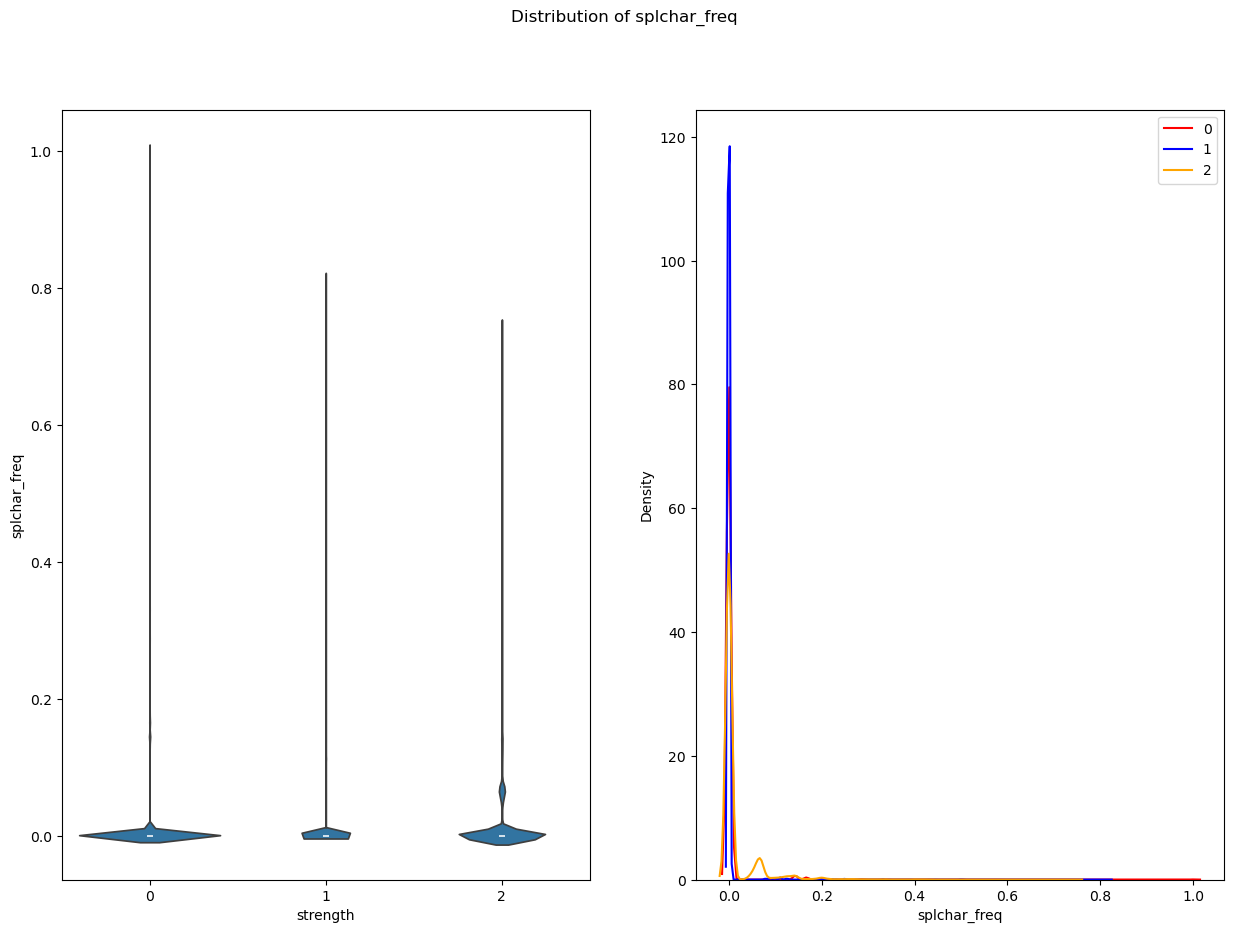

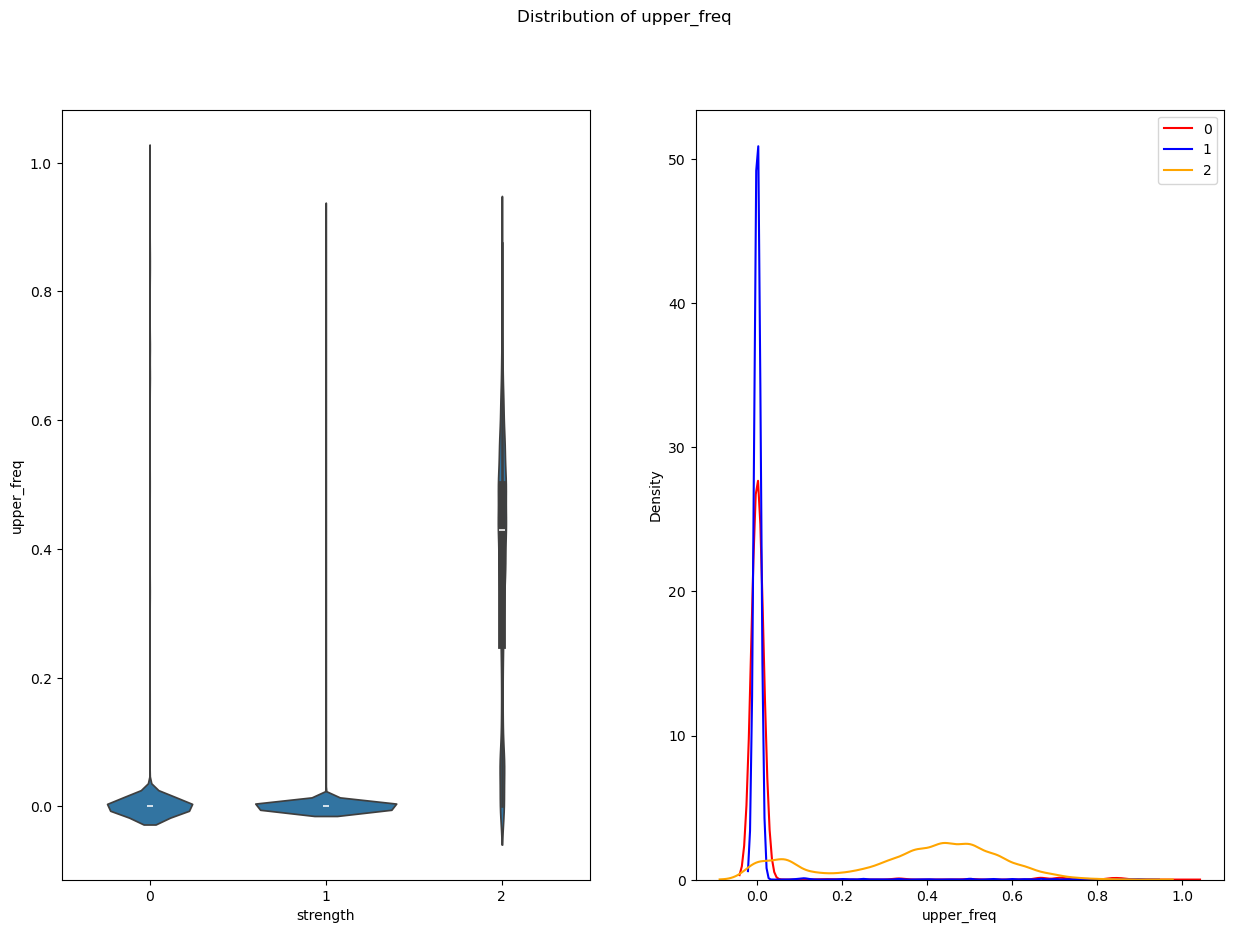

In [32]:
for col in cols:
    plot(col)

The significance of each feature in predicting password strength involves analysis of the extent of overlap in distribution curves for different strength categories. Features demonstrating minimal overlap were identified as having higher importance in predicting password strength. Here ‘Length’ feature does not have any overlap among its distribution curves for different strengths, and lower_case_frequency has next least overlap in its distribution across the 3 strength categories, remaining features are observed to have a significantly large amount of overlaps. .This methodology provides valuable insights into the distinctiveness of feature distributions and aids in understanding their relevance to the overall predictive model. 


### Term Frequency-Inverse Document Frequency (TF-IDF) vectorization
Converting the password(text) into machine readable format(vector).
1. TF is a measure of how frequently a term t, appears in a document d. We calculate the char frequencies for all the characters and all the passwords in this manner.
2. IDF is a measure of how important a term is.
3. We can now compute the TF-IDF score for each character in the passwords dataset. Character  with a higher score are more important, and those with a lower score are less important.

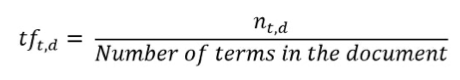 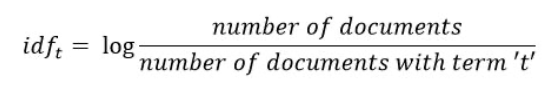 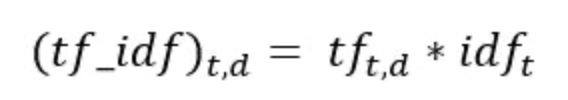

In [33]:
df1=df.sample(frac=1) # shuffling 

In [34]:
df1.head(2)

,password,strength,length,lower_freq,upper_freq,num_freq,splchar_freq
83741,u2j9o3uz,1,8,0.625,0.0,0.375,0.0
87407,jekakde88,1,9,0.778,0.0,0.222,0.0


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
vectorizer = TfidfVectorizer(analyzer='char') # the analyzer=char converts the password strings into list format.

In [37]:
x=list(df1['password'])

In [38]:
X=vectorizer.fit_transform(x) 

In [39]:
X.shape  # every password is represeneted using 99 dimensions.

(100000, 99)

In [40]:
X  # sparse matrix - most of the values are 0

<100000x99 sparse matrix of type '<class 'numpy.float64'>'
	with 842571 stored elements in Compressed Sparse Row format>

In [41]:
X.toarray()[0] # vector representation of df1['password'].head(1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2600372 , 0.2912428 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31424837,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3755785 , 0.        , 0.        , 0.        ,
       0.        , 0.26596978, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.62338432, 0.        , 0.        ,
       0.        , 0.        , 0.38522604, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [42]:
df1['password'].head(1)

83741    u2j9o3uz
Name: password, dtype: object

In [43]:
vectorizer.get_feature_names_out() # 99 dimensions used to represent password

array(['\x04', '\x06', '\x08', '\x0e', '\x10', '\x11', '\x17', ' ', '!',
       '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?',
       '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¨',
       '°', '±', '³', '´', 'µ', '·', 'ß', 'à', 'á', 'ä', 'æ', 'ç', 'é',
       'ê', 'í', 'ñ', 'ó', 'õ', 'ö', '÷', 'ú', 'ü', 'ý', 'þ', '›'],
      dtype=object)

In [44]:
# storing the vectors in a data frame
df2=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

In [45]:
df2.head(2)

,,,,,,,,,!,#,...,ñ,ó,õ,ö,÷,ú,ü,ý,þ,›
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# add the previously created length and lower_case_freq features to the above dataframe 
df2['length']=df1['length']
df2['lowercase_freq']=df1['lower_freq']

In [47]:
df2.shape

(100000, 101)

In [48]:
df2

,,,,,,,,,!,#,...,õ,ö,÷,ú,ü,ý,þ,›,length,lowercase_freq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,0.417
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.778
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.783
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.700
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.800
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.778
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.667


### Modelling

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
y=df1['strength']

In [51]:
x_train,x_test,y_train,y_test=train_test_split(df2,y,test_size=0.20)

In [52]:
x_train.shape 

(80000, 101)

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
clf=LogisticRegression(multi_class='multinomial') # multinomial as we have more than 2 classes for strength.

In [55]:
clf.fit(x_train,y_train)

LogisticRegression(multi_class='multinomial')

In [56]:
y_pred=clf.predict(x_test)

In [57]:
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [58]:
from collections import Counter

In [59]:
Counter(y_pred)

Counter({1: 16686, 2: 1708, 0: 1606})

### Performance of the Model

In [60]:
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

In [61]:
accuracy_score(y_test,y_pred)

0.8043

In [62]:
confusion_matrix(y_test,y_pred)

array([[  865,  1878,     1],
       [  668, 13797,   283],
       [   73,  1011,  1424]])

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.32      0.40      2744
           1       0.83      0.94      0.88     14748
           2       0.83      0.57      0.68      2508

    accuracy                           0.80     20000
   macro avg       0.73      0.61      0.65     20000
weighted avg       0.79      0.80      0.79     20000



### Automation on user input

In [64]:
password='@#!*87dsf'

In [65]:
sample_array=np.array([password])
sample_array

array(['@#!*87dsf'], dtype='<U9')

In [66]:
sample_matrix=vectorizer.transform(sample_array) # as the model vectorizer is already fitted on training data we use transform instead of fit_transform
sample_matrix.toarray().shape

(1, 99)

In [67]:
new_matrix=np.append(sample_matrix.toarray(),(len(password),len([char for char in password if char.islower()])/len(password))).reshape(1,101)

In [68]:
new_matrix.shape

(1, 101)

In [69]:
def predict():
    password=input('Enter a password: ')
    sample_array=np.array([password])
    sample_matrix=vectorizer.transform(sample_array)
    l=len(password)
    a=len([char for char in password if char.islower])/l
    new_matrix=np.append(sample_matrix.toarray(),(l,a)).reshape(1,101)
    result=clf.predict(new_matrix)
    if result ==0:
        return "Password is weak"
    elif result == 0:
        return "Password is weak"
    else:
        return "Password is strong"
    

In [70]:
predict()

Enter a password:  hnasfjafahy


'Password is strong'